In [1]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from models import CNN

Using TensorFlow backend.


In [2]:
# The data, split between train and test sets:
(X_train, y_train), (X, y) = cifar10.load_data()
print(X.shape)
print(y.shape)
print(np.min(X), np.max(X))

(10000, 32, 32, 3)
(10000, 1)
0 255


In [3]:
encoder = CNN(X.shape[1:])
_ = encoder(np.random.rand(1,32,32,3).astype(np.float32))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline

In [5]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto').fit(np.reshape(X_train,(X_train.shape[0], -1)), y_train.squeeze())

/home/thallessilva/anaconda3/envs/tf2.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [6]:
print("Train score:", clf.score(np.reshape(X_train,(X_train.shape[0], -1)), y_train),
      "Test score:", clf.score(np.reshape(X_test,(X_test.shape[0], -1)), y_test))

Train score: 0.4815 Test score: 0.388


## Self-Supervised pre-training

In [7]:
X_train_repr, _ = encoder(tf.cast(X_train, tf.float32) / 255, training=True)
X_test_repr, _ = encoder(tf.cast(X_test, tf.float32) / 255, training=True)
print(X_train_repr.shape)
print(X_test_repr.shape)

(8000, 64)
(2000, 64)


In [8]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto').fit(X_train_repr, y_train.squeeze())

/home/thallessilva/anaconda3/envs/tf2.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [9]:
print(clf.score(X_train_repr, y_train.squeeze()), clf.score(X_test_repr, y_test.squeeze()))
# 0.333

0.41 0.3765


In [10]:
X_train_repr[0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([0.9877376 , 1.291688  , 0.94789505, 1.0242503 , 0.9259114 ,
       1.3375256 , 0.6599454 , 1.0366911 , 0.918199  , 1.2183697 ,
       0.7277174 , 0.98015773, 1.1094345 , 1.4269246 , 0.7431276 ,
       0.93318164, 0.7825998 , 0.8070295 , 2.1381342 , 0.6814266 ,
       0.15767087, 0.5336    , 1.6411939 , 1.6537368 , 0.33571443,
       0.81801295, 0.5415913 , 0.77718776, 0.9537431 , 1.0449755 ,
       1.1843491 , 1.1581521 , 1.7765427 , 0.7688685 , 0.5137994 ,
       1.9452035 , 0.89624137, 1.1433065 , 0.9553189 , 1.3854    ,
       0.91827494, 1.0162283 , 0.56204134, 1.0575916 , 0.88932496,
       0.8844476 , 0.44248322, 0.7263912 , 0.781695  , 0.75292903,
       0.64554334, 0.6033028 , 0.42532334, 1.20373   , 1.0509102 ,
       1.029772  , 0.980548  , 0.25524646, 0.6795023 , 1.0191046 ,
       1.0212545 , 0.7047734 , 1.2244837 , 0.1741183 ], dtype=float32)>

In [11]:
X_test_repr[0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([0.48438543, 1.107085  , 1.3198764 , 1.1276953 , 1.2153352 ,
       0.76859105, 0.78863096, 0.25211436, 0.90524405, 0.6600803 ,
       0.5210695 , 0.8627778 , 0.50941485, 1.0363326 , 0.9314529 ,
       0.8295021 , 0.7586357 , 1.0317823 , 0.29104218, 0.47168124,
       0.68653774, 1.0084099 , 1.0879703 , 1.5259866 , 0.84300244,
       0.8733821 , 0.7990243 , 0.67872065, 0.8022594 , 1.0281502 ,
       0.91603804, 0.7491348 , 0.9870279 , 1.1949191 , 0.83879876,
       0.24403733, 0.77000475, 0.9594132 , 1.4442179 , 0.98421896,
       0.9238106 , 0.72643924, 0.7564484 , 0.6951094 , 1.0213232 ,
       0.9016768 , 1.7896891 , 0.6840965 , 1.1426873 , 0.5269377 ,
       1.0643253 , 0.5901062 , 1.2055218 , 0.765487  , 1.0559077 ,
       0.50405896, 0.59914476, 0.5105461 , 0.77519536, 0.83468765,
       1.2816627 , 1.003029  , 1.4140126 , 0.7084505 ], dtype=float32)>

In [12]:
cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
loss = cosine_loss([[0.0001, 1], [1., 1]], [[0.0002, 1], [0., 1]])

print('Loss: ', loss.numpy())  # Loss: 0.5

Loss:  -0.8535534


In [13]:
a = tf.convert_to_tensor([1,6,5], dtype=tf.int32)
b = tf.convert_to_tensor([4,3,2], dtype=tf.int32)
res = tf.sets.intersection(a[None,:],b[None,:])
print(tf.size(res))

tf.Tensor(0, shape=(), dtype=int32)


In [14]:
a = np.array([28.171087, 30.802778], dtype=np.float32)
b = np.array([2.2323670e-06, 2.1488113e-06], dtype=np.float32)

print(a / (a+b))

[0.99999994 0.99999994]


In [15]:
samples = tf.random.categorical(tf.math.log([[0.5, 0.5]]), 5)
samples

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1, 1, 0, 1, 1]])>

In [261]:
indices = tf.constant([[1], [3]])
updates = tf.constant([0, 0])

tensor = tf.ones([10], dtype=tf.int32)
mask = tf.tensor_scatter_nd_update(tensor, indices, updates)
print(mask)

p = tf.ones(10)
p = p * tf.cast(mask, tf.float32)
p = p / tf.reduce_sum(p)
print(p)

samples = tf.random.categorical(tf.math.log(tf.reshape(p, (1,-1))), 100) # note log-prob
print(samples)

tf.Tensor([1 0 1 0 1 1 1 1 1 1], shape=(10,), dtype=int32)
tf.Tensor([0.125 0.    0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125], shape=(10,), dtype=float32)
tf.Tensor(
[[2 9 8 8 2 9 6 4 9 4 2 7 2 9 6 5 6 5 0 0 4 9 8 0 2 2 2 4 5 6 9 8 5 9 2 6
  8 2 8 9 7 8 7 0 5 6 8 0 7 7 6 5 6 8 9 9 4 6 8 7 9 7 6 8 5 5 8 6 4 7 8 6
  5 8 7 8 9 7 5 8 0 0 0 2 8 8 9 0 4 0 2 0 8 6 5 5 4 8 7 0]], shape=(1, 100), dtype=int64)


(array([12.,  0., 11.,  0.,  8., 12., 13., 11., 20., 13.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

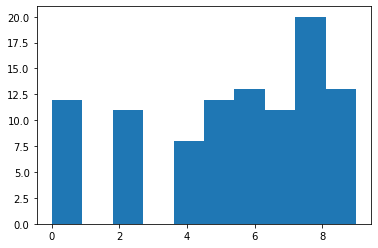

In [262]:
plt.hist(samples)

In [210]:
# positive_indices = tf.constant([1,2], dtype=tf.int32)
# a = 

indices = tf.constant([[4], [3], [1], [7]])
updates = tf.constant([0, 0, 0, 0])

tensor = tf.ones([8], dtype=tf.int32)
mask = tf.tensor_scatter_nd_update(tensor, indices, updates)
print(updated)

tf.Tensor([1 0 1 0 0 1 1 0], shape=(8,), dtype=int32)
